# **Node Classification in the Amazon Product Graph**

## **Libraries**

In [1]:
!pip install torch torchvision torchaudio
!pip install torch-geometric ogb
!pip install seaborn

In [2]:
import torch
from torch.serialization import add_safe_globals
from torch_geometric.data.data import Data
from torch_geometric.data.data import DataEdgeAttr
from torch_geometric.data import Data
from ogb.nodeproppred import NodePropPredDataset
from torch_geometric.loader import NeighborLoader
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
add_safe_globals({'torch_geometric.data.data.Data': Data})
add_safe_globals({'torch_geometric.data.data.DataEdgeAttr': DataEdgeAttr})

## **Loading the ogbn-products Dataset**

In [4]:
dataset = NodePropPredDataset(name='ogbn-products')
split_idx = dataset.get_idx_split()

graph, labels = dataset[0]

print(graph)

Downloaded 1.38 GB: 100%|██████████| 1414/1414 [00:23<00:00, 61.16it/s]


Extracting dataset/products.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Saving...
{'edge_index': array([[      0,  152857,       0, ..., 2449028,   53324, 2449028],
       [ 152857,       0,   32104, ...,  162836, 2449028,   53324]]), 'edge_feat': None, 'node_feat': array([[ 0.03193326, -0.1958605 ,  0.0519961 , ...,  0.07669606,
        -0.3929545 , -0.06478424],
       [-0.02405794,  0.63032097,  1.0605699 , ..., -1.6874819 ,
         3.5866776 ,  0.818219  ],
       [ 0.33269015, -0.5585958 , -0.28860757, ..., -0.37157044,
         0.2520575 ,  0.04153213],
       ...,
       [ 0.10660695,  0.2654852 , -0.00567423, ...,  1.0867023 ,
         0.07590195, -1.1736895 ],
       [ 0.24968362, -0.25740346,  0.41230008, ...,  1.5465808 ,
         1.0309792 , -0.29657176],
       [ 0.7175324 , -0.23930131,  0.04430327, ..., -1.0132493 ,
        -0.41407427, -0.08227058]], dtype=float32), 'num_nodes': 2449029}


## **Preprocessing and Preparing Data Graphs**

In [ ]:
edge_index = torch.tensor(graph['edge_index'], dtype=torch.long)
x = torch.tensor(graph['node_feat'], dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long).squeeze()

data = Data(x=x, edge_index=edge_index, y=y)

train_idx = split_idx["train"]
valid_idx = split_idx["valid"]
test_idx = split_idx["test"]

print(data)
print(f"# Train samples: {train_idx.shape[0]}")
print(f"# Valid samples: {valid_idx.shape[0]}")
print(f"# Test samples: {test_idx.shape[0]}")

Data(x=[2449029, 100], edge_index=[2, 123718280], y=[2449029])
# Train samples: 196615
# Valid samples: 39323
# Test samples: 2213091


## **GCN and GraphSAGE Models**

In [6]:
# Model GCN
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Model GraphSAGE
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

## **Evaluate Model**

In [7]:
@torch.no_grad()
def evaluate_model(model, data, train_idx, valid_idx, test_idx):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    accs, f1s = [], []
    for split in [train_idx, valid_idx, test_idx]:
        correct = (pred[split] == data.y[split]).sum().item()
        acc = correct / split.shape[0]
        f1 = f1_score(data.y[split].cpu(), pred[split].cpu(), average='macro')
        accs.append(acc)
        f1s.append(f1)
    return accs, f1s

## **Train Model**

In [8]:
def train_model(model, data, train_idx, valid_idx, test_idx, epochs=20):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    model.to(device)
    data = data.to(device)

    train_acc_list, val_acc_list, test_acc_list = [], [], []
    val_f1_list, test_f1_list = [], []
    train_loss_list = []

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.cross_entropy(out[train_idx], data.y[train_idx])
        loss.backward()
        optimizer.step()

        accs, f1s = evaluate_model(model, data, train_idx, valid_idx, test_idx)

        # Saving
        train_acc_list.append(accs[0])
        val_acc_list.append(accs[1])
        test_acc_list.append(accs[2])
        val_f1_list.append(f1s[1])
        test_f1_list.append(f1s[2])
        train_loss_list.append(loss.item())

        print(f"[Epoch {epoch:02d}] Loss: {loss.item():.4f} | "
              f"Train Acc: {accs[0]:.4f} | Val Acc: {accs[1]:.4f} | Test Acc: {accs[2]:.4f} || "
              f"Val F1: {f1s[1]:.4f} | Test F1: {f1s[2]:.4f}")

    return {
        'train_acc': train_acc_list,
        'val_acc': val_acc_list,
        'test_acc': test_acc_list,
        'val_f1': val_f1_list,
        'test_f1': test_f1_list,
        'train_loss': train_loss_list
    }

## **Training and Evaluating Models**

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
# Model : GCN
gcn_model = GCN(in_channels=data.num_node_features, hidden_channels=128, out_channels=dataset.num_classes)
print("\n🧠 Training GCN:")
gcn_results = train_model(gcn_model, data, train_idx, valid_idx, test_idx, epochs=100)


🧠 Training GCN:


[Epoch 01] Loss: 3.8042 | Train Acc: 0.4541 | Val Acc: 0.4406 | Test Acc: 0.3227 || Val F1: 0.0849 | Test F1: 0.0637
[Epoch 02] Loss: 3.2017 | Train Acc: 0.6063 | Val Acc: 0.6040 | Test Acc: 0.4582 || Val F1: 0.1784 | Test F1: 0.1065
[Epoch 03] Loss: 2.6883 | Train Acc: 0.6775 | Val Acc: 0.6756 | Test Acc: 0.5119 || Val F1: 0.2220 | Test F1: 0.1308
[Epoch 04] Loss: 2.2596 | Train Acc: 0.7058 | Val Acc: 0.7005 | Test Acc: 0.5318 || Val F1: 0.2380 | Test F1: 0.1424
[Epoch 05] Loss: 1.9099 | Train Acc: 0.7217 | Val Acc: 0.7165 | Test Acc: 0.5427 || Val F1: 0.2479 | Test F1: 0.1495
[Epoch 06] Loss: 1.6348 | Train Acc: 0.7336 | Val Acc: 0.7274 | Test Acc: 0.5511 || Val F1: 0.2588 | Test F1: 0.1567
[Epoch 07] Loss: 1.4271 | Train Acc: 0.7476 | Val Acc: 0.7400 | Test Acc: 0.5615 || Val F1: 0.2725 | Test F1: 0.1658
[Epoch 08] Loss: 1.2731 | Train Acc: 0.7618 | Val Acc: 0.7546 | Test Acc: 0.5739 || Val F1: 0.2886 | Test F1: 0.1756
[Epoch 09] Loss: 1.1561 | Train Acc: 0.7771 | Val Acc: 0.7695 | 

In [11]:
# Model : GraphSAGE
sage_model = GraphSAGE(in_channels=data.num_node_features, hidden_channels=128, out_channels=dataset.num_classes)
print("\n🧠 Training GraphSAGE:")
sage_results = train_model(sage_model, data, train_idx, valid_idx, test_idx, epochs=100)


🧠 Training GraphSAGE:


[Epoch 01] Loss: 3.9385 | Train Acc: 0.3003 | Val Acc: 0.2975 | Test Acc: 0.2179 || Val F1: 0.0965 | Test F1: 0.0567
[Epoch 02] Loss: 3.1026 | Train Acc: 0.5975 | Val Acc: 0.5842 | Test Acc: 0.4275 || Val F1: 0.1604 | Test F1: 0.0932
[Epoch 03] Loss: 2.4482 | Train Acc: 0.6544 | Val Acc: 0.6417 | Test Acc: 0.4855 || Val F1: 0.1813 | Test F1: 0.1063
[Epoch 04] Loss: 1.9398 | Train Acc: 0.6344 | Val Acc: 0.6224 | Test Acc: 0.4798 || Val F1: 0.1844 | Test F1: 0.1124
[Epoch 05] Loss: 1.5868 | Train Acc: 0.6249 | Val Acc: 0.6143 | Test Acc: 0.4758 || Val F1: 0.1990 | Test F1: 0.1216
[Epoch 06] Loss: 1.3782 | Train Acc: 0.6480 | Val Acc: 0.6356 | Test Acc: 0.4896 || Val F1: 0.2247 | Test F1: 0.1367
[Epoch 07] Loss: 1.2478 | Train Acc: 0.6958 | Val Acc: 0.6814 | Test Acc: 0.5235 || Val F1: 0.2580 | Test F1: 0.1592
[Epoch 08] Loss: 1.1274 | Train Acc: 0.7496 | Val Acc: 0.7340 | Test Acc: 0.5627 || Val F1: 0.2914 | Test F1: 0.1790
[Epoch 09] Loss: 1.0192 | Train Acc: 0.7839 | Val Acc: 0.7681 | 

## **Confusion Matrix**

### **GCN Model**

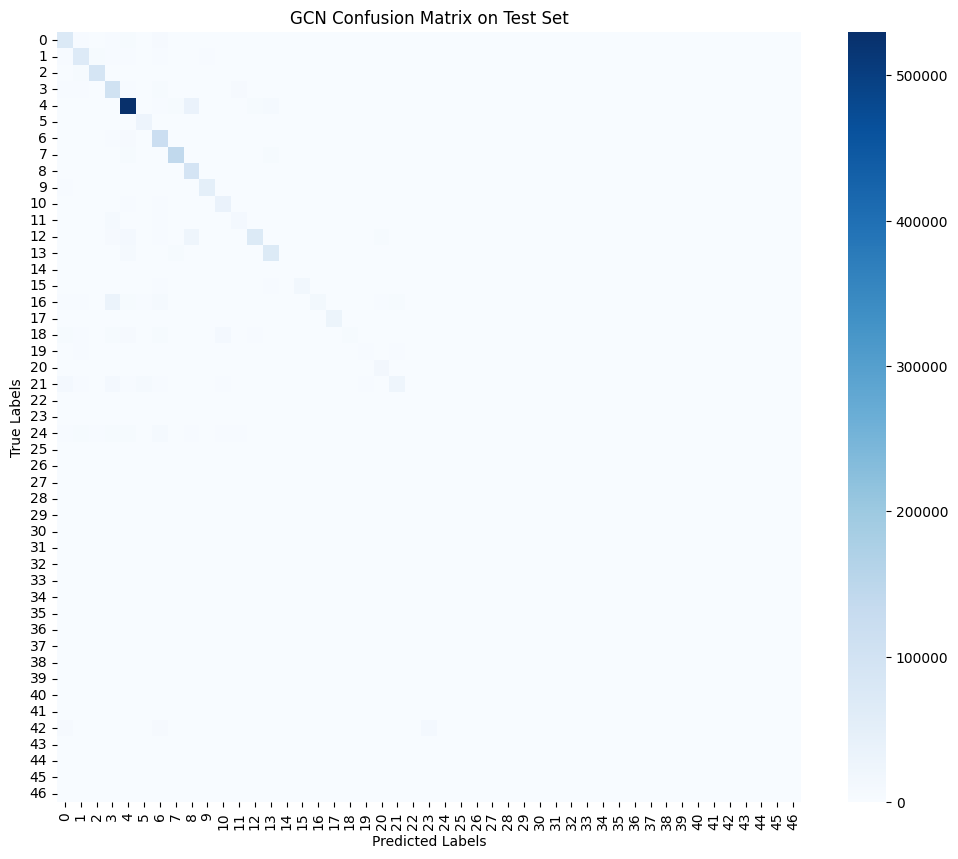

In [12]:
# Final evaluation of the GCN model and plotting the confusion matrix
with torch.no_grad():
    # Get predictions for the entire graph
    out = gcn_model(data.x.to(device), data.edge_index.to(device))
    pred = out.argmax(dim=1)

    # Isolate the predictions and true labels for the test set
    y_true_test = data.y[test_idx].cpu().numpy()
    y_pred_test = pred[test_idx].cpu().numpy()

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true_test, y_pred_test)
    
    # Plot the confusion matrix using a heatmap
    plt.figure(figsize=(12, 10))
    # annot=False because with 47 classes, the numbers would be unreadable
    sns.heatmap(cm, annot=False, cmap='Blues', fmt='d')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('GCN Confusion Matrix on Test Set')
    plt.show()

### **SAGE Model**

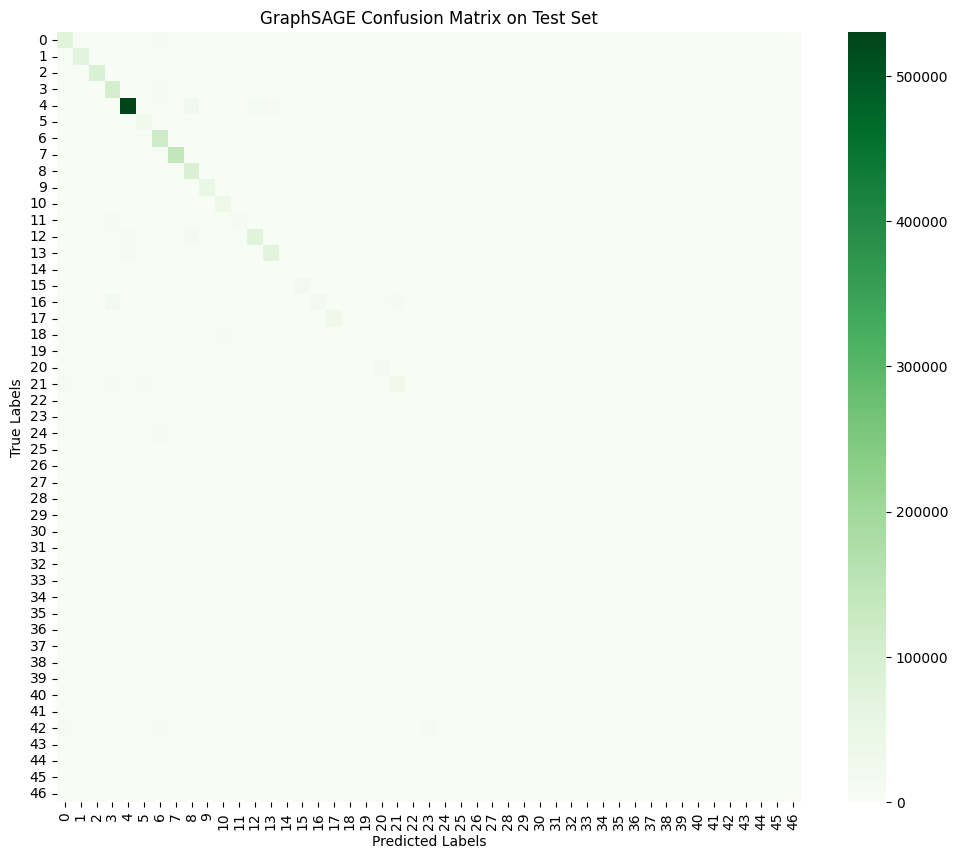

In [13]:
# Final evaluation of the GraphSAGE model and plotting the confusion matrix
with torch.no_grad():
    # Get predictions for the entire graph
    out = sage_model(data.x.to(device), data.edge_index.to(device))
    pred = out.argmax(dim=1)

    # Isolate the predictions and true labels for the test set
    y_true_test_sage = data.y[test_idx].cpu().numpy()
    y_pred_test_sage = pred[test_idx].cpu().numpy()

    # Calculate the confusion matrix
    cm_sage = confusion_matrix(y_true_test_sage, y_pred_test_sage)

    # Plot the confusion matrix using a heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_sage, annot=False, cmap='Greens', fmt='d')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('GraphSAGE Confusion Matrix on Test Set')
    plt.show()

## **Visualization of Results**

### **GCN Results**

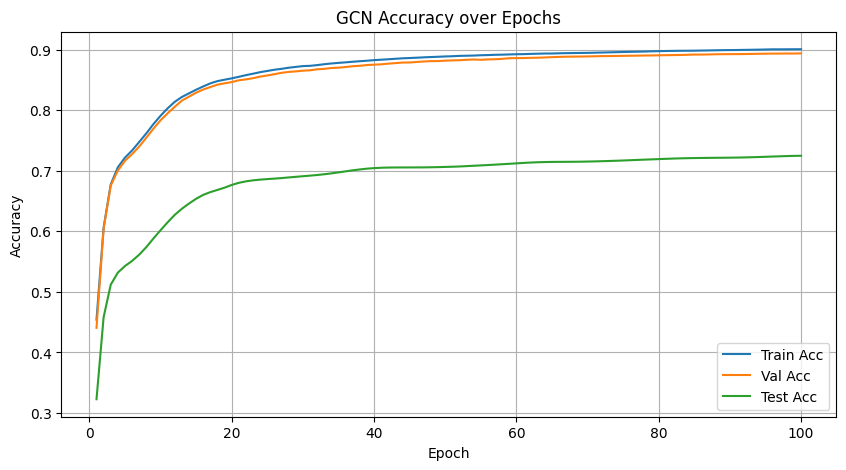

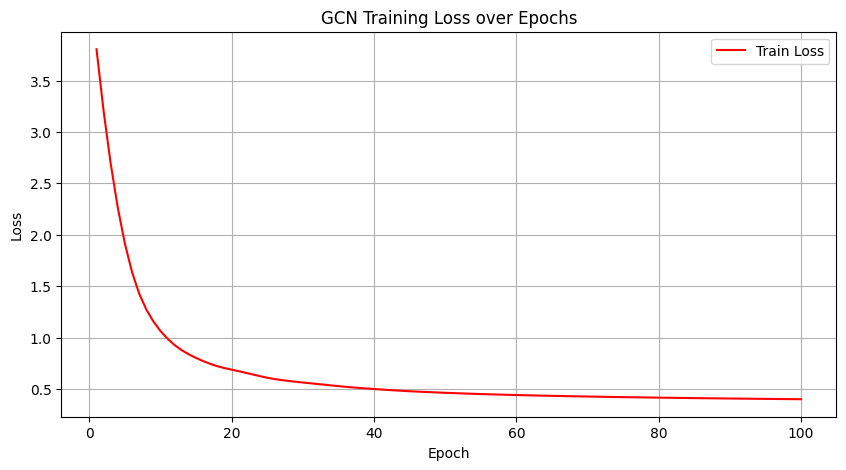

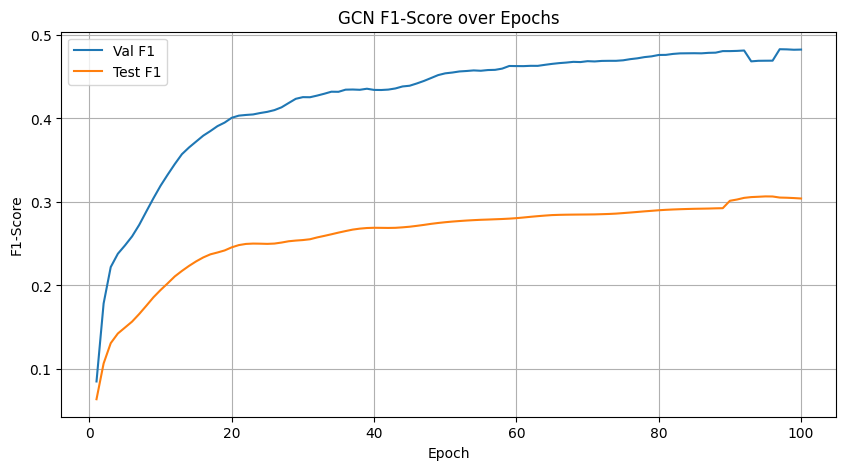

In [14]:
epochs = range(1, len(gcn_results['train_acc']) + 1)

# 🎯 Accuracy
plt.figure(figsize=(10,5))
plt.plot(epochs, gcn_results['train_acc'], label='Train Acc')
plt.plot(epochs, gcn_results['val_acc'], label='Val Acc')
plt.plot(epochs, gcn_results['test_acc'], label='Test Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("GCN Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# 🎯 Loss
plt.figure(figsize=(10,5))
plt.plot(epochs, gcn_results['train_loss'], label='Train Loss', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GCN Training Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# 🎯 F1-Score
plt.figure(figsize=(10,5))
plt.plot(epochs, gcn_results['val_f1'], label='Val F1')
plt.plot(epochs, gcn_results['test_f1'], label='Test F1')
plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.title("GCN F1-Score over Epochs")
plt.legend()
plt.grid(True)
plt.show()

### **SAGE Results**

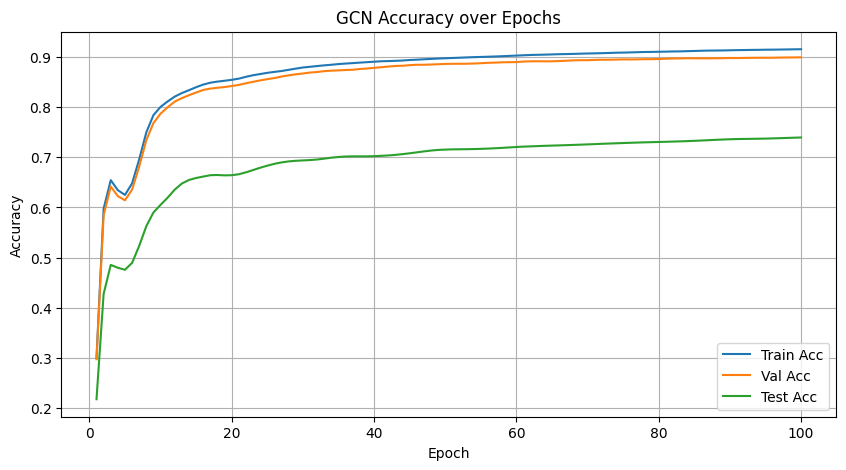

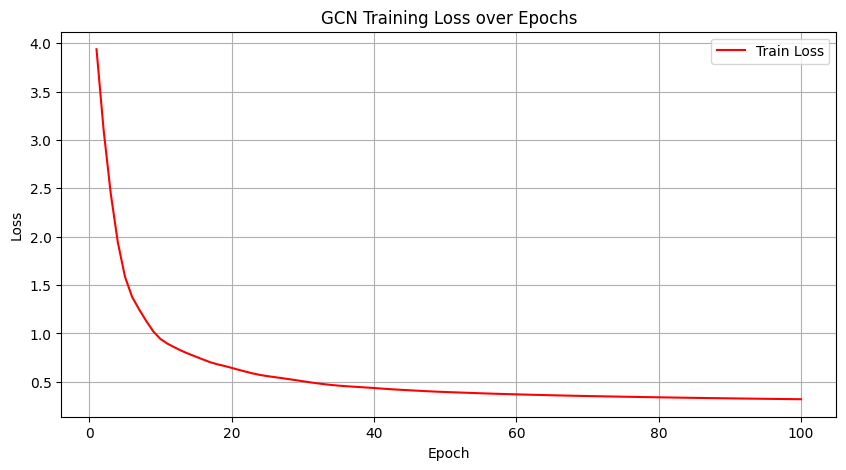

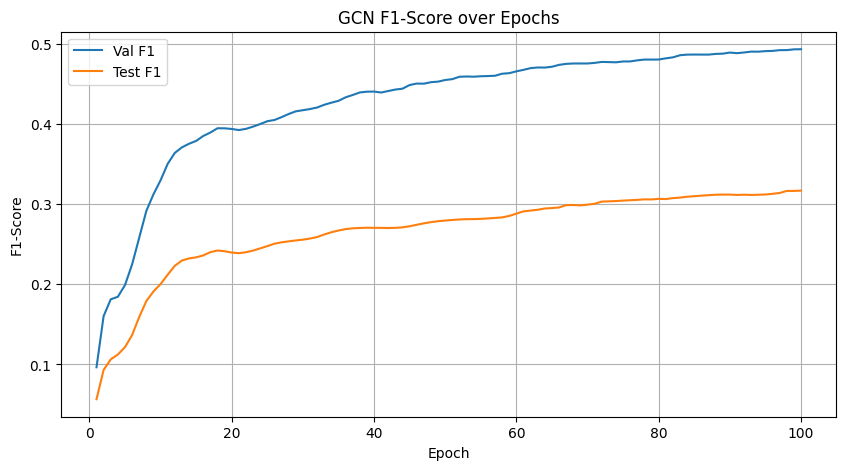

In [15]:
epochs = range(1, len(sage_results['train_acc']) + 1)

# 🎯 Accuracy
plt.figure(figsize=(10,5))
plt.plot(epochs, sage_results['train_acc'], label='Train Acc')
plt.plot(epochs, sage_results['val_acc'], label='Val Acc')
plt.plot(epochs, sage_results['test_acc'], label='Test Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("GCN Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# 🎯 Loss
plt.figure(figsize=(10,5))
plt.plot(epochs, sage_results['train_loss'], label='Train Loss', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GCN Training Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# 🎯 F1-Score
plt.figure(figsize=(10,5))
plt.plot(epochs, sage_results['val_f1'], label='Val F1')
plt.plot(epochs, sage_results['test_f1'], label='Test F1')
plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.title("GCN F1-Score over Epochs")
plt.legend()
plt.grid(True)
plt.show()

## **THE END**